In [52]:
import wandb
import pandas as pd
from simpletransformers.t5 import T5Model
import yaml
import ast

import sklearn
from sklearn.model_selection import train_test_split

In [4]:
# Loading Credentials
with open("credentials.yaml", 'r') as stream:
    credentials = yaml.safe_load(stream)

In [94]:
%env WANDB_API_KEY=4d65a39548ffa3dc3f80181e7d16107fafcfa535

env: WANDB_API_KEY=4d65a39548ffa3dc3f80181e7d16107fafcfa535


In [7]:
wandbApiKey = credentials['wandb']['key']

In [9]:
data = pd.read_csv('competitors_reddit.csv')

In [12]:
data.shape

(1974, 6)

## Preparing data for Title Recognition

In [17]:
data['reply_body_list']=data['reply_body'].apply(ast.literal_eval)

In [19]:
data['submission_selftext'] = data['submission_selftext'].fillna("")

In [20]:
data.head(5)

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body,reply_body_list
0,0,f96vya,New versions of A5 and A6 Agile firmwares are ...,NaN,"Dear Supernote users, new versions of A5 and A...","[""There was video of a multifunction button to...",[There was video of a multifunction button to ...
1,1,f9dsst,Feature request. Pressure sensitivity.,NaN,Thank you for the new firmware update. It adds...,['We are happy that you can enjoy this firmwar...,[We are happy that you can enjoy this firmware...
2,2,fp66n4,Quick Guide — Set Up and Connect to the Supern...,NaN,Set up and connect to the Supernote Cloud acco...,"[""What I would like to know is where can one b...",[What I would like to know is where can one bu...
3,3,fs454n,How to use handwriting to text function?,NaN,How do you achieve this? I've not been able to...,"['Currently you can try the ""Smart Writing"" fu...","[Currently you can try the ""Smart Writing"" fun..."
4,4,fs46fj,Email inbox issues,NaN,"I have set up my email, and can send emails. M...","[""Hi aubrit512,\n\nPlease try to update the sy...","[Hi aubrit512,\n\nPlease try to update the sys..."


In [21]:
# Combining text

In [22]:
def firstNComments(commentList, n=3):
    m = len(commentList)
    if m==0:
        return ""
    
    return " ".join(commentList[:min(n,m)])

In [42]:
data['all_text'] = data.apply(lambda x: " ".join([ \
     x['submission_selftext'], \
     firstNComments(x['reply_body_list'], n=4) \
    ] ),axis=1)

In [43]:
print("All data:", len(data))
print("Data with title not nan:",sum(data['submission_title'].notna()))
print("Data with title > 0 characters long",sum(data['submission_title'].apply(lambda x: len(x.strip()))>0))

print("So no need to remove data with no title")

All data: 1974
Data with title not nan: 1974
Data with title > 0 characters long 1974
So no need to remove data with no title


In [45]:
data.head(5)

,index,submission_id,submission_title,submission_link_flair_text,submission_selftext,reply_body,reply_body_list,all_text
0,0,f96vya,New versions of A5 and A6 Agile firmwares are ...,NaN,"Dear Supernote users, new versions of A5 and A...","[""There was video of a multifunction button to...",[There was video of a multifunction button to ...,"Dear Supernote users, new versions of A5 and A..."
1,1,f9dsst,Feature request. Pressure sensitivity.,NaN,Thank you for the new firmware update. It adds...,['We are happy that you can enjoy this firmwar...,[We are happy that you can enjoy this firmware...,Thank you for the new firmware update. It adds...
2,2,fp66n4,Quick Guide — Set Up and Connect to the Supern...,NaN,Set up and connect to the Supernote Cloud acco...,"[""What I would like to know is where can one b...",[What I would like to know is where can one bu...,Set up and connect to the Supernote Cloud acco...
3,3,fs454n,How to use handwriting to text function?,NaN,How do you achieve this? I've not been able to...,"['Currently you can try the ""Smart Writing"" fu...","[Currently you can try the ""Smart Writing"" fun...",How do you achieve this? I've not been able to...
4,4,fs46fj,Email inbox issues,NaN,"I have set up my email, and can send emails. M...","[""Hi aubrit512,\n\nPlease try to update the sy...","[Hi aubrit512,\n\nPlease try to update the sys...","I have set up my email, and can send emails. M..."


## Train Test Split

In [48]:
all_titles_df = data[['all_text','submission_title']] \
    .rename(columns={"all_text":"input_text","submission_title":"target_text"})

In [68]:
all_titles_df['prefix']='title prediction'

In [69]:
all_titles_df.head(5)

,input_text,target_text,prefix
0,"Dear Supernote users, new versions of A5 and A...",New versions of A5 and A6 Agile firmwares are ...,title prediction
1,Thank you for the new firmware update. It adds...,Feature request. Pressure sensitivity.,title prediction
2,Set up and connect to the Supernote Cloud acco...,Quick Guide — Set Up and Connect to the Supern...,title prediction
3,How do you achieve this? I've not been able to...,How to use handwriting to text function?,title prediction
4,"I have set up my email, and can send emails. M...",Email inbox issues,title prediction


In [70]:
all_titles_df.to_csv('all_titles_df.csv',index=False)

In [71]:
train_title_df,val_title_df=train_test_split(all_titles_df, test_size=0.1,random_state=42)

In [72]:
print("train size:",len(train_title_df))
print("test size:",len(val_title_df))

train size: 1776
test size: 198


## Loading Tag Data

In [73]:
train_tag_df = pd.read_csv('singletask_train.csv')
val_tag_df = pd.read_csv('singlatask_noupsampling_val.csv')

In [88]:
train_tag_df['prefix']=''
val_tag_df['prefix']=''

In [89]:
train_tag_df.head(5)

,input_text,target_text,prefix
0,Battery drain i’ve been using my ipadpro for n...,Question,
1,GoodNotes on iCloud I can not find my GoodNote...,Question,
2,Flash card shuffle? Is there a way to shuffle ...,Question,
3,First Attempt With GoodNotes! Any thought? Ni...,Review,
4,Which backup is the best for good notes - Drop...,Question,


## Combining DataSets

In [90]:
train_combined_df = pd.concat([train_title_df,train_tag_df])
val_combined_df = pd.concat([val_title_df,val_tag_df])

In [91]:
print("train:",train_combined_df.shape)
print("test:",val_combined_df.shape)

train: (2088, 3)
test: (247, 3)


## 3. Model Training

In [96]:
model_args = {
    "output_dir": './single-task-noupsample', #specify output directory
    "max_seq_length": 400,
    "train_batch_size": 2,
    "eval_batch_size": 2,
    "num_train_epochs": 3,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000,
    "evaluate_during_training_verbose": True,
    "use_multiprocessing": False,
    "fp16": False,
    "save_steps": -1,
    "save_eval_checkpoints": False,
    "save_model_every_epoch": False,
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "wandb_project": "T5 - multi task",
    "use_cuda": False
}

In [97]:
model = T5Model("t5", "t5-small", args=model_args, use_cuda=False)
model.train_model(train_combined_df, eval_data=val_combined_df)

  0%|          | 0/2088 [00:00<?, ?it/s]

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


Using Adafactor for T5


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific argum

Running Epoch 2 of 3:   0%|          | 0/1044 [00:00<?, ?it/s]

  0%|          | 0/247 [00:00<?, ?it/s]

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific argum

(3132,
 {'global_step': [1044, 2088, 3132],
  'eval_loss': [0.5957901629416512, 0.1593266632140923, 0.07726606870035597],
  'train_loss': [1.01181960105896, 0.02049863524734974, 0.49937084317207336]})

## Evaluation

In [98]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
y_true = val_tag_df["target_text"].tolist()

In [100]:
# Prepare the data for testing
to_predict = [
    prefix + ": " + str(input_text)
    for prefix, input_text in zip(val_tag_df["prefix"].tolist(), val_tag_df["input_text"].tolist())
]
#y_true = val_tag_df["target_text"].tolist()
tasks = val_tag_df["prefix"].tolist()

# Get the model predictions
y_pred = model.predict(to_predict)

Generating outputs:   0%|          | 0/25 [00:00<?, ?it/s]

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_grad

Decoding outputs:   0%|          | 0/49 [00:00<?, ?it/s]

/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x14b2b71f0> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function TorchHistory._hook_variable_gradient_stats.<locals>.<lambda> at 0x14b2b7310> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/torch/utils/hooks.py:59: UserWarning: backward hook <function Tor

In [101]:
print(classification_report(y_true, y_pred))

                 precision    recall  f1-score   support

       Question       0.92      0.92      0.92        39
         Review       0.50      0.50      0.50         2
Stylus problems       0.00      0.00      0.00         2
      Templates       0.75      1.00      0.86         6

       accuracy                           0.88        49
      macro avg       0.54      0.61      0.57        49
   weighted avg       0.85      0.88      0.86        49



/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roman/test/code/manning/manning-lp/myvenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [102]:
labels = train_tag_df['target_text'].unique()

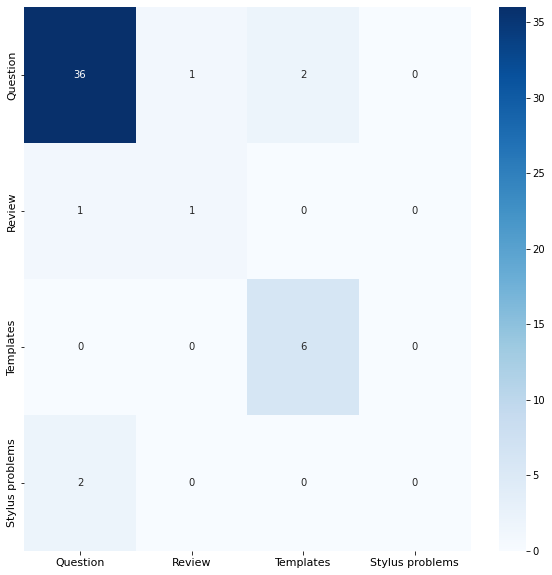

In [103]:
cm = confusion_matrix(y_true, y_pred, labels=labels)
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xticklabels(labels,fontsize=11)
ax.set_yticklabels(labels,fontsize=11);
#plt.xlabel('Predicted')
#plt.ylabel('True')

## Publishing Model to Hugging Face Repo

In [104]:
model.push_to_hub("my-awesome-model", use_auth_token="api_PKetuiPRMMMERwpYBsgdQcIAAuODMgkuiF")

AttributeError: 'T5Model' object has no attribute 'push_to_hub'